In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffusion import GaussianDiffusion
from torchvision.datasets import CIFAR10, FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
from PIL import Image
from unet import UNet
import torchvision.transforms as transforms

In [3]:
path = "./data"
dataset = FashionMNIST(root=path, train=True, download=True, transform=v2.Compose([
    v2.ToTensor(),
    v2.Resize((32, 32))
]))

dataloader = DataLoader(dataset, batch_size=2)

/home/ubuntu/.cache/pypoetry/virtualenvs/ddpm-NolEjOLK-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
def display_image(img):
    """
    batch: (1, C, H, W)
    """
    figure(figsize=(2, 2))
    img = img.permute((1, 2, 0))
    plt.imshow(img, cmap="gray")

In [5]:
for batch in dataloader:
    X = batch[0]
    break

/home/ubuntu/.cache/pypoetry/virtualenvs/ddpm-NolEjOLK-py3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [6]:
X.shape

torch.Size([2, 1, 32, 32])

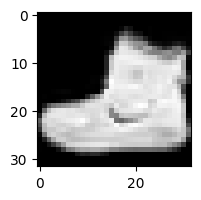

In [7]:
display_image(X[0])

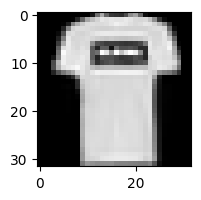

In [8]:
display_image(X[1])

In [9]:
unet = UNet(in_channels=1, model_channels=64, out_channels=1, channel_mult=(1, 2, 4), attention_resolutions=[2], num_res_blocks=2)
unet

UNet(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Swish()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (in_layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downsamples): ModuleList(
    (0-1): 2 x TimeSequential(
      (layers): ModuleList(
        (0): ResNetBlock(
          (in_layers): Sequential(
            (0): GroupNorm(32, 64, eps=1e-05, affine=True)
            (1): Swish()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_layers): Sequential(
            (0): Swish()
            (1): Linear(in_features=256, out_features=64, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm(32, 64, eps=1e-05, affine=True)
            (1): Swish()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (s

In [10]:
unet(X, torch.tensor([5, 6])).shape

torch.Size([2, 1, 32, 32])

In [11]:
beta_start = 0.0001
beta_end = 0.02
T = 1000

diffusion = GaussianDiffusion(
    beta_start=beta_start,
    beta_end=beta_end,
    timesteps=T
)

In [71]:
noise = torch.randn_like(X)
noise.shape

torch.Size([2, 1, 32, 32])

In [72]:
t = torch.tensor([999]*2)
x_T = diffusion.q_sample(X, t, noise)
x_T.shape

torch.Size([2, 1, 32, 32])

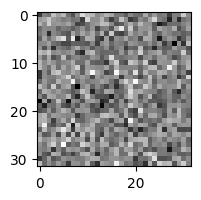

In [73]:
display_image(x_T[0])

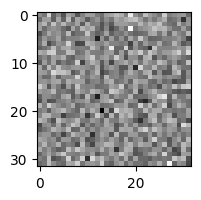

In [74]:
display_image(x_T[1])

In [75]:
# make model that returns predicted noise
def create_model(noise):
    def model(x, t):
        # return torch.randn((1, 1, 28, 28))
        # return torch.randn((1, 3, 32, 32))
        return noise
    
    return model

In [77]:
model = create_model(noise)
model

<function __main__.create_model.<locals>.model(x, t)>

In [35]:
sample = diffusion.sample(model, x_T)

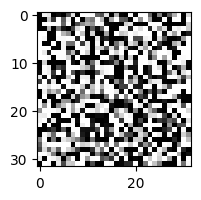

In [36]:
display_image(sample[0])

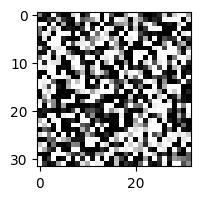

In [37]:
display_image(sample[1])

In [52]:
samples = []

x_t = x_T
x_0 = X

for t in range(T - 1, -1, -1):
    t = torch.tensor([t])
    mean, var = diffusion.q_posterior_mean_var(x_t, x_0, t)
    z = torch.randn_like(x_t)
    x_t = mean + (var ** 0.5) * z
    samples.append(x_t) 

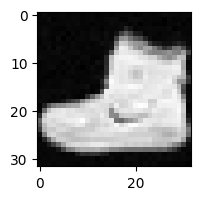

In [55]:
i = 999

display_image(samples[i][0])

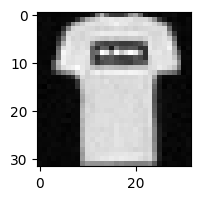

In [56]:
display_image(samples[i][1])

In [94]:
t = torch.tensor([999] * 2)
pred_noise = model(X, t)

In [95]:
model(
X, 0
)

tensor([[[[-1.7728, -0.0848, -0.3950,  ..., -0.1842,  1.7374,  0.1723],
          [ 0.5263,  0.8423,  1.6371,  ..., -2.1535, -0.4162, -0.0097],
          [ 1.1674,  0.1858,  1.8028,  ..., -0.6016, -0.0112,  0.3504],
          ...,
          [ 0.2705, -1.0539, -1.4393,  ..., -0.8757, -0.9106, -0.6909],
          [-1.7463, -0.7607,  0.5617,  ...,  1.0680, -0.5506,  0.1713],
          [ 1.3564, -0.6985,  0.2488,  ...,  0.6439,  1.8225, -0.0973]]],


        [[[ 0.1381, -0.5526,  2.2910,  ...,  0.3388,  0.5055, -0.8998],
          [-0.8585,  0.5686,  0.6397,  ...,  0.0396, -2.5714,  0.1960],
          [ 0.5160,  1.3045, -0.6138,  ...,  1.1680, -0.3805,  0.3775],
          ...,
          [-1.0122, -0.1286,  0.6939,  ..., -1.9367,  0.5752,  0.5668],
          [-0.2293, -0.7210,  1.5476,  ...,  0.8833,  1.4477, -1.6353],
          [-0.9254, -0.5485,  1.5623,  ...,  0.2790, -0.1290, -1.8896]]]])

In [96]:
pred_x0 = (x_T - (1 - diffusion.alpha_bar[t]).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) ** 0.5 * pred_noise) / diffusion.alpha_bar[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) ** 0.5

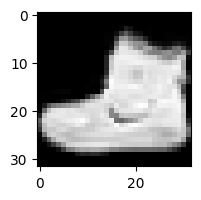

In [97]:
display_image(pred_x0[0])

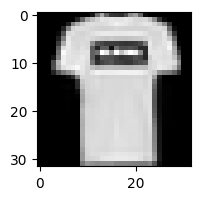

In [98]:
display_image(pred_x0[1])

In [102]:
noise = torch.randn((64, 1, 32, 32))

model = create_model(noise)

samples = diffusion.sample(model, noise, clip_denoised=True)
samples.shape

torch.Size([64, 1, 32, 32])

In [103]:
from PIL import Image
import torchvision.transforms.functional as F

def batch_to_images(batch):
    images = []

    for tensor in batch:
        mode = "RGB" if tensor.shape[0] == 3 else "L"
        image = F.to_pil_image(tensor, mode=mode)
        images.append(image)
        

    return images

In [104]:
batch_to_images(samples)

<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B4D60>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B62C0>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B4D60>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B62C0>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B4D60>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B62C0>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B4D60>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B62C0>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B4D60>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B62C0>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B4D60>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B62C0>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B4D60>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B62C0>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B4D60>
<PIL.Image.Image image mode=L size=32x32 at 0x14A6BC2B62C0>
<PIL.Image.Image image mode=L size=32x32

[]